Pythonで実装してみる。書籍の内容を完全にはカバーしてません。

# 自己回帰モデル: ARモデル

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale = 1.5)
c_list = sns.color_palette().as_hex()
color_num = len(c_list)

## ARモデルのパラメータ決定
### 対象データ

データはこれ

https://archive.ics.uci.edu/ml/machine-learning-databases/00409/Daily_Demand_Forecasting_Orders.csv

区切り文字が`;`なので注意。というかなんでこんな区切り文字使うの？？？何処かの業界では普通なの？？

In [2]:
demand = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/00409/Daily_Demand_Forecasting_Orders.csv", 
    sep=";"
)
demand.head()

,"Week of the month (first week, second, third, fourth or fifth week",Day of the week (Monday to Friday),Non-urgent order,Urgent order,Order type A,Order type B,Order type C,Fiscal sector orders,Orders from the traffic controller sector,Banking orders (1),Banking orders (2),Banking orders (3),Target (Total orders)
0,1,4,316.307,223.270,61.543,175.586,302.448,0.000,65556,44914,188411,14793,539.577
1,1,5,128.633,96.042,38.058,56.037,130.580,0.000,40419,21399,89461,7679,224.675
2,1,6,43.651,84.375,21.826,25.125,82.461,1.386,11992,3452,21305,14947,129.412
3,2,2,171.297,127.667,41.542,113.294,162.284,18.156,49971,33703,69054,18423,317.120
4,2,3,90.532,113.526,37.679,56.618,116.220,6.459,48534,19646,16411,20257,210.517


In [3]:
demand.columns

Index(['Week of the month (first week, second, third, fourth or fifth week',
       'Day of the week (Monday to Friday)', 'Non-urgent order',
       'Urgent order', 'Order type A', 'Order type B', 'Order type C',
       'Fiscal sector orders', 'Orders from the traffic controller sector',
       'Banking orders (1)', 'Banking orders (2)', 'Banking orders (3)',
       'Target (Total orders)'],
      dtype='object')

### データの確認

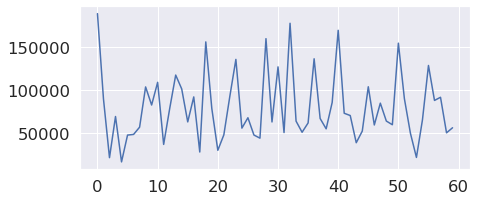

In [4]:
fig = plt.figure(figsize=(7, 3))
ax = fig.subplots(1, 1)
ax.plot(demand['Banking orders (2)']);

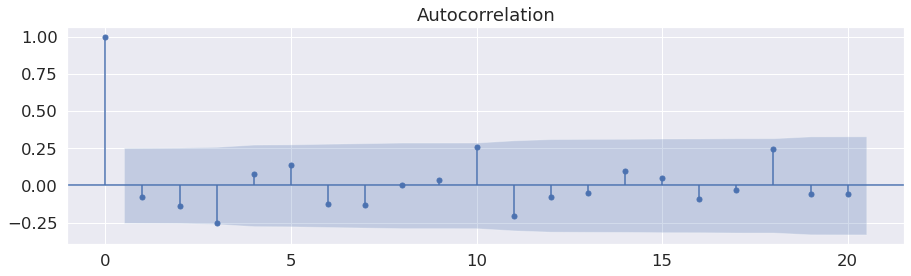

In [5]:
fig = plt.figure(figsize=(15, 4))
ax = fig.subplots(1, 1)
sm.graphics.tsa.plot_acf(demand['Banking orders (2)'], lags=20, fft=False, ax=ax);

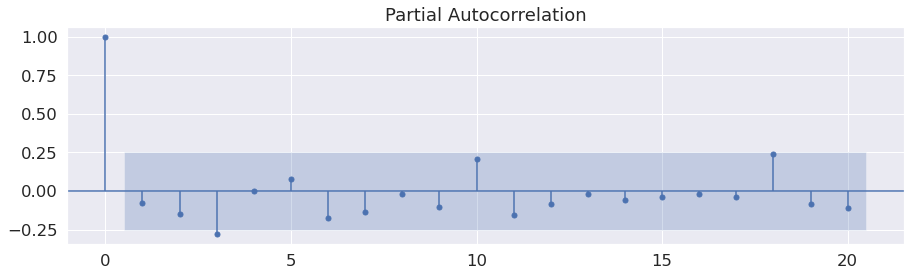

In [6]:
fig = plt.figure(figsize=(15, 4))
ax = fig.subplots(1, 1)
sm.graphics.tsa.plot_pacf(demand['Banking orders (2)'], lags=20, method="ldb", ax=ax);

### パラメータ推定

statsmodelsのAPIをそのまま使うだけ。

In [7]:
ar_model = sm.tsa.arima.ARIMA(
    demand['Banking orders (2)'], 
    order=(3, 0, 0)
)
ar_res = ar_model.fit()
print(ar_res.summary())

                               SARIMAX Results                                
Dep. Variable:     Banking orders (2)   No. Observations:                   60
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -717.601
Date:                Thu, 25 Nov 2021   AIC                           1445.202
Time:                        09:14:17   BIC                           1455.674
Sample:                             0   HQIC                          1449.298
                                 - 60                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        7.94e+04   3631.436     21.865      0.000    7.23e+04    8.65e+04
ar.L1         -0.1353      0.181     -0.746      0.456      -0.491       0.220
ar.L2         -0.2016      0.111     -1.810      0.0

`arma_order_select_ic`を使うと、ARMAモデルの次数の提案もしてくれる。

In [8]:
sm.tsa.arma_order_select_ic(
    demand['Banking orders (2)'], 
    ic='aic', trend='nc'
)

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.war

{'aic':              0            1            2
 0          NaN  1516.138218  1496.330208
 1  1485.206287  1454.813185  1456.442488
 2  1477.014625  1536.790653  1457.707350
 3  1476.890973  1457.391848  1460.586689
 4  1468.226838  1454.360452  1456.355501,
 'aic_min_order': (4, 1)}

上記の結果では、行でARの次数、列にMAの次数でAICの値が出てくる。

残差のACFの確認

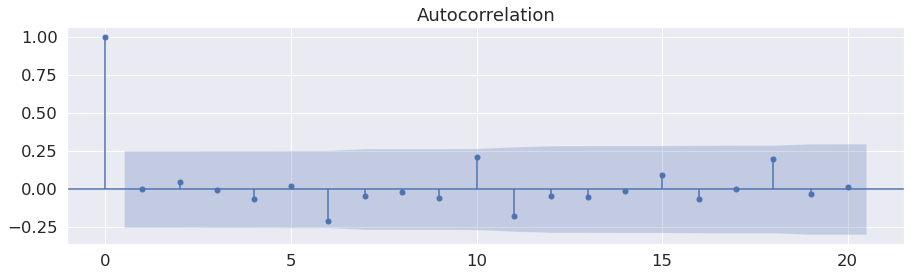

In [9]:
fig = plt.figure(figsize=(15, 4))
ax = fig.subplots(1, 1)
sm.graphics.tsa.plot_acf(ar_res.resid, lags=20, fft=False, ax=ax);

### 予測

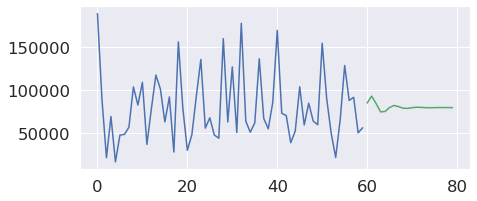

In [10]:
fig = plt.figure(figsize=(7, 3))
ax = fig.subplots(1, 1)
ax.plot(demand['Banking orders (2)']);
ax.plot(ar_res.forecast(steps=20), color=c_list[2])

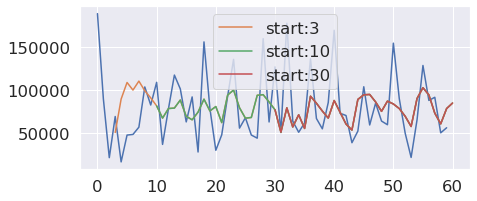

In [11]:
fig = plt.figure(figsize=(7, 3))
ax = fig.subplots(1, 1)
ax.plot(demand['Banking orders (2)']);

for i, h in enumerate([3, 10, 30]):
    tmp = ar_res.get_prediction(start=h, end=demand.shape[0])
    ax.plot(tmp.predicted_mean, color=c_list[i+1], label=f"start:{h}")
ax.legend();

`get_prediction`がRの`fetted`に相当するのかと思ったけど、違うなー。ちゃんとドキュメントを読もう。

# 移動平均モデル: MAモデル

## MAモデルのパラメータ決定

### パラメータ推定

データはARIMAモデルで使ったものと同じ。

ACFの確認した結果から、MA(10)を当てる?

In [12]:
ma10_model = sm.tsa.arima.ARIMA(
    demand['Banking orders (2)'], 
    order=(0, 0, 10)
)
ma10_res = ma10_model.fit()
print(ma10_res.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:     Banking orders (2)   No. Observations:                   60
Model:                ARIMA(0, 0, 10)   Log Likelihood                -711.947
Date:                Thu, 25 Nov 2021   AIC                           1447.895
Time:                        09:14:42   BIC                           1473.027
Sample:                             0   HQIC                          1457.725
                                 - 60                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        7.94e+04   4887.227     16.247      0.000    6.98e+04     8.9e+04
ma.L1         -0.1312      6.553     -0.020      0.984     -12.976      12.713
ma.L2         -0.1030      1.481     -0.070      0.9

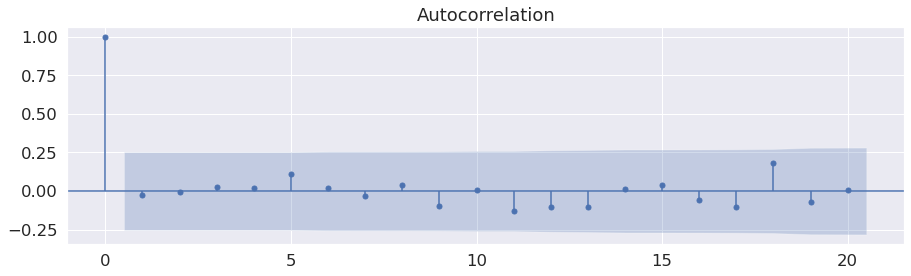

In [13]:
fig = plt.figure(figsize=(15, 4))
ax = fig.subplots(1, 1)
sm.graphics.tsa.plot_acf(ma10_res.resid, lags=20, fft=False, ax=ax);

In [14]:
ma3_model = sm.tsa.arima.ARIMA(
    demand['Banking orders (2)'], 
    order=(0, 0, 3)
)
ma3_res = ma3_model.fit()
print(ma3_res.summary())

                               SARIMAX Results                                
Dep. Variable:     Banking orders (2)   No. Observations:                   60
Model:                 ARIMA(0, 0, 3)   Log Likelihood                -717.049
Date:                Thu, 25 Nov 2021   AIC                           1444.099
Time:                        09:14:43   BIC                           1454.571
Sample:                             0   HQIC                          1448.195
                                 - 60                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        7.94e+04   1898.751     41.818      0.000    7.57e+04    8.31e+04
ma.L1         -0.0619      0.100     -0.618      0.537      -0.258       0.134
ma.L2         -0.1090      0.119     -0.916      0.3

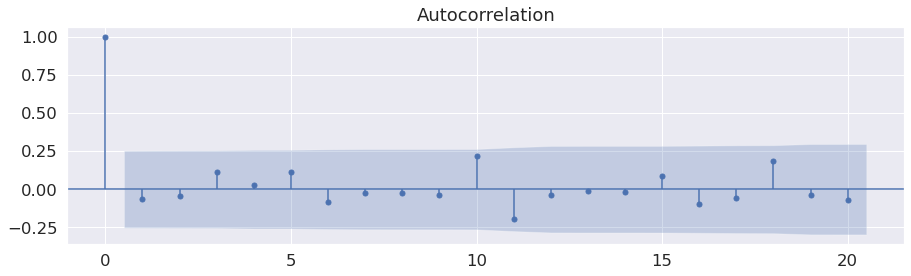

In [15]:
fig = plt.figure(figsize=(15, 4))
ax = fig.subplots(1, 1)
sm.graphics.tsa.plot_acf(ma3_res.resid, lags=20, fft=False, ax=ax);

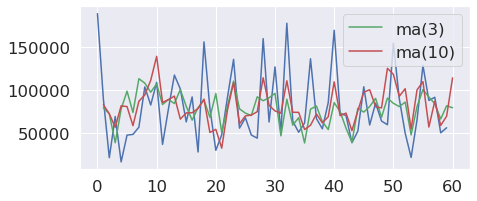

In [16]:
fig = plt.figure(figsize=(7, 3))
ax = fig.subplots(1, 1)
ax.plot(demand['Banking orders (2)']);
tmp = ma3_res.get_prediction(start=1, end=demand.shape[0])
ax.plot(tmp.predicted_mean, color=c_list[2], label=f"ma(3)")

tmp = ma10_res.get_prediction(start=1, end=demand.shape[0])
ax.plot(tmp.predicted_mean, color=c_list[3], label=f"ma(10)")

ax.legend();

# 自己回帰和分移動平均モデル


## ARIMAモデルのパラメータ選択

### データ

~トイデータを作成する~

航空機データを使う

In [17]:
url_csv = "https://raw.githubusercontent.com/PracticalTimeSeriesAnalysis/" \
          "BookRepo/master/Ch02/data/AirPassengers.csv"

air = pd.read_csv(url_csv, parse_dates = True, header = None)
air.columns = ['Date', 'Passengers']
air["Date"] = pd.to_datetime(air.Date, format="%Y-%m")
air.set_index("Date", inplace=True)
air.head()

,Passengers
Date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


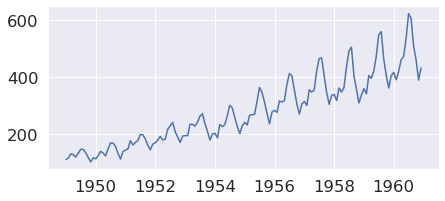

In [18]:
fig = plt.figure(figsize=(7, 3))
ax = fig.subplots(1, 1)
ax.plot(air.Passengers);

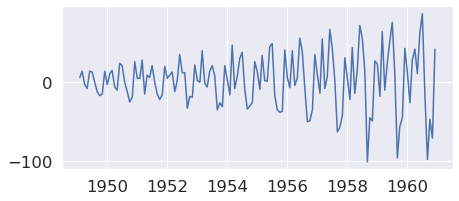

In [19]:
fig = plt.figure(figsize=(7, 3))
ax = fig.subplots(1, 1)
ax.plot(air.diff().Passengers);

１階差分をとることで、定常っぽくなった

季節周期ははっきりと出ている（12ヶ月周期でACFが跳ねている）

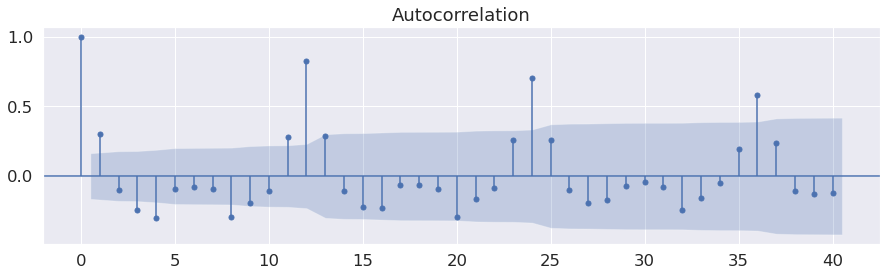

In [20]:
fig = plt.figure(figsize=(15, 4))
ax = fig.subplots(1, 1)
sm.graphics.tsa.plot_acf(air.diff().Passengers[1:], lags=40, fft=False, ax=ax);

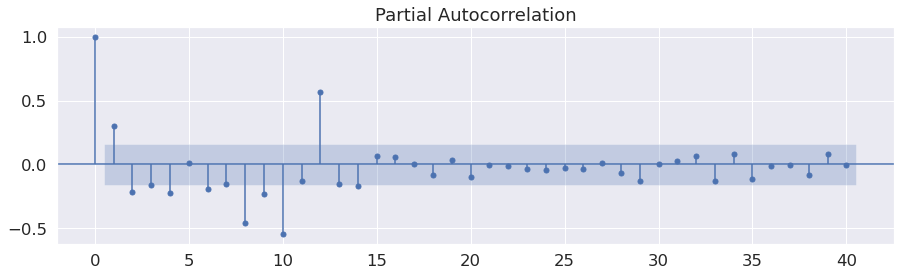

In [21]:
fig = plt.figure(figsize=(15, 4))
ax = fig.subplots(1, 1)
sm.graphics.tsa.plot_pacf(air.diff().Passengers[1:], lags=40, method="ldb", ax=ax);

差分データに対して、ARMAモデルの次数予測をする。

In [22]:
sm.tsa.arma_order_select_ic(
    air.diff().Passengers[1:], 
    ic='aic', trend='nc'
)

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


{'aic':              0            1            2
 0          NaN  1397.257791  1397.093436
 1  1401.852641  1412.615224  1385.496795
 2  1396.587654  1378.338024  1353.175684
 3  1395.021214  1379.614000  1351.138684
 4  1388.216680  1379.616584  1373.560615,
 'aic_min_order': (3, 2)}

この結果を利用して、ARIMA(3, 1, 2)モデルを当てはめる。

In [23]:
arima_model = sm.tsa.arima.ARIMA(
    air.Passengers, 
    order=(3, 1, 2)
)
arima_res = arima_model.fit()
print(arima_res.summary())


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-inv

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -682.543
Date:                Thu, 25 Nov 2021   AIC                           1377.086
Time:                        09:14:56   BIC                           1394.863
Sample:                    01-01-1949   HQIC                          1384.310
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2580      0.135      1.914      0.056      -0.006       0.522
ar.L2          0.3732      0.136      2.736      0.006       0.106       0.641
ar.L3         -0.3367      0.125     -2.684      0.0

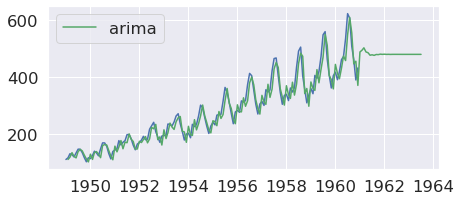

In [24]:
fig = plt.figure(figsize=(7, 3))
ax = fig.subplots(1, 1)
ax.plot(air.Passengers);
tmp = arima_res.get_prediction(start=1, end=air.shape[0]+30)
ax.plot(tmp.predicted_mean, color=c_list[2], label=f"arima")
ax.legend();

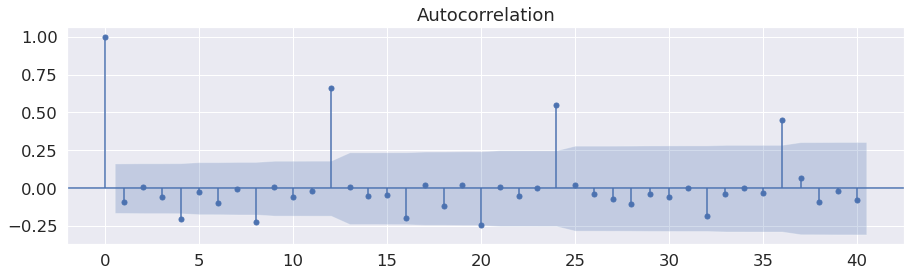

In [28]:
fig = plt.figure(figsize=(15, 4))
ax = fig.subplots(1, 1)
sm.graphics.tsa.plot_acf(arima_res.resid, lags=40, fft=False, ax=ax);

季節変動があるから、SARIMAモデルを使う必要がある。

# 自己回帰モデルのメモ

AR(1)モデルを適当に設定して、データを生成してみる

In [26]:
def ar1(phi, size=10, y0=0.0, stddev_e=1.0):
    ys = [y0]
    for i in range(size):
        yt = phi[0] + phi[1] * ys[i] + np.random.normal(loc=0, scale=stddev_e)
        ys.append(yt)
    return ys

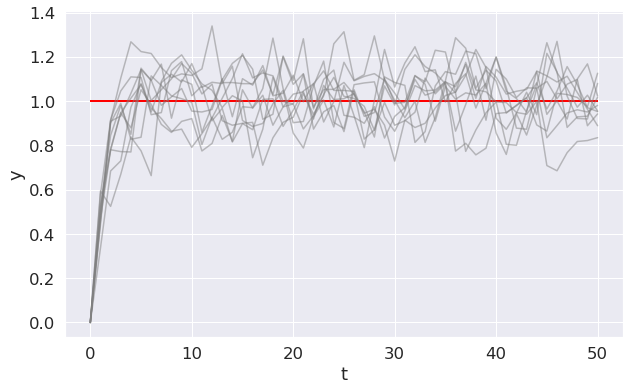

In [27]:
fig = plt.figure(figsize=(10, 6))
ax = fig.subplots(1, 1)

phi = [0.5, 0.5]
mu = phi[0] / (1 - phi[1])
n = 50
for i in range(10):
    ys = ar1(phi=phi, size=n, stddev_e=0.1)
    ax.plot(ys, alpha=0.5, color="gray")
ax.hlines(y=mu, xmin=0, xmax=n, color="red", lw=2)
ax.set_xlabel("t");
ax.set_ylabel("y");

期待値（赤線）の付近をばらつくことがわかる。